Department of Probability and Statistics\
University of California, Santa Barbara
### PSTAT 135 Big Data Analytics
# Analyzing Voter Participation Disparities in the United States: A Big Data Approach

Ryan Yee, George Weale, Sarah Liang, and Ryan Lee
#### March 20, 2024

## Abstract

This PSTAT 135/235 project investigates racial disparities in voter turnout across the U.S., leveraging extensive voter files and big data tools with PySpark and Dataproc. Aimed at identifying the underlying causes of these disparities, the study examines demographic, socioeconomic, and geographic influences. Through data analysis, we hope to find insights for policies that could help our political campaign.

In order to be able to complete necessary computing in an efficient manner, we decided to narrow our focus on Georgia. As a swing state, this will help prevent imbalances between democratic and republican voters and provide us with an insightful area to investigate. Our goal is to further understand voting patterns and behavior of U.S. residents, especially when considering differences between and affects of affluent versus non-affluent regions, voting by mail, and accessory lifestyle interests. Some of our specific research questions that we intend to investigate are the following:

- What are the leading causes for disparity in turnout for voters of different ethnicity?
- What are some of the disparities in interests/lifestyle (leisure activity, sports, arts, travel etc.) that impact voter turnout?
- How does affluence of residential regions impact voter turnout?

## Preliminary Findings

In [2]:
import pandas as pd
from statsmodels.graphics.factorplots import interaction_plot
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql import functions as fn
import seaborn as sns
from pyspark.sql.functions import *
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import RFormula
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql import functions as fn
from pyspark.sql import SparkSession
from pyspark import SparkConf

from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("Read Voter File Data") \
    .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/03/20 04:38:42 INFO SparkEnv: Registering MapOutputTracker
24/03/20 04:38:42 INFO SparkEnv: Registering BlockManagerMaster
24/03/20 04:38:43 INFO SparkEnv: Registering BlockManagerMasterHeartbeat
24/03/20 04:38:43 INFO SparkEnv: Registering OutputCommitCoordinator


In [3]:
ga_data = spark.read.format("parquet").option('nullValue','null').load("gs://voter-files-16/VM2Uniform--GA--2021-04-16/*.parquet")

In [4]:
ga_samp = ga_data.sample(withReplacement=False, fraction=0.01, seed=42)

#### What are leading causes for disparity in turnout for voters of different ethnicity?

To specify our analysis on turnout for voters of different ethnicities, we wanted to subset our dataset to only the Murray county in order to gain a clearer understanding of the distribution of voters by ethnicity. To specify even further, we narrowed down the age group to include the voters that aged from 18 - 30 years of age.

In [26]:
murray_county = ga_data[fn.col('County') == 'MURRAY'].cache()
murray_county.count()
young_voters = murray_county.withColumn('Voters_Age',fn.col('Voters_Age').cast('int')) \
            .filter((fn.col('Voters_Age') >= 18) & (fn.col('Voters_Age') <= 30)).cache()
young_voters.count()
#young_voters.select([fn.count(fn.when(fn.isnull(c), c)).alias(c) for c in young_voters.columns]).show()

4877

In [5]:
young_voters.select(fn.col('Ethnic_Description')).distinct().show()

+--------------------+
|  Ethnic_Description|
+--------------------+
|African or Af-Am ...|
|     Native American|
|               Scots|
|             Chinese|
|Russian (omitting...|
|                Arab|
|                null|
|               Irish|
|        Indian/Hindu|
|              Polish|
|                Manx|
|Likely Af-Am (Mod...|
| Dutch (Netherlands)|
|          Vietnamese|
|             Serbian|
|          Portuguese|
|           Hungarian|
|            Austrian|
|             Italian|
|              Danish|
+--------------------+
only showing top 20 rows



<AxesSubplot:title={'center':'Count of Ethnicities in Dataset'}, xlabel='Ethnicity', ylabel='# of Registered Voters'>

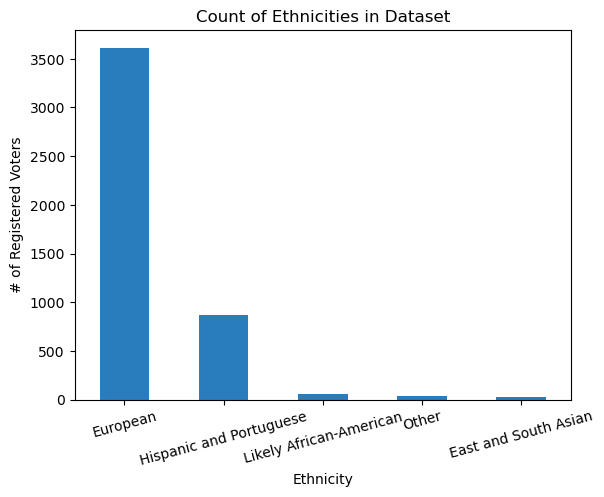

In [6]:
df_GA_ethnicgroup = young_voters.select(['EthnicGroups_EthnicGroup1Desc'])

df_GA_ethnicgroup = df_GA_ethnicgroup.groupBy('EthnicGroups_EthnicGroup1Desc')\
    .agg(count('EthnicGroups_EthnicGroup1Desc').alias('ethnicgroup_count')) \
    .orderBy(col('ethnicgroup_count').desc()).dropna()

df_GA_ethnicgroup_plt = df_GA_ethnicgroup.toPandas()
plt.rcParams.update({'font.size': 10})
df_GA_ethnicgroup_plt.plot.bar(x = 'EthnicGroups_EthnicGroup1Desc', y = 'ethnicgroup_count', 
                               xlabel = 'Ethnicity', ylabel = '# of Registered Voters', 
                               title = 'Count of Ethnicities in Dataset', rot = 15, legend = False, color = '#2A7DBD')

<AxesSubplot:title={'center':'General 2020 Election Turnout by Ethnicity'}, xlabel='Ethnicity', ylabel='General 2020 Election Turnout'>

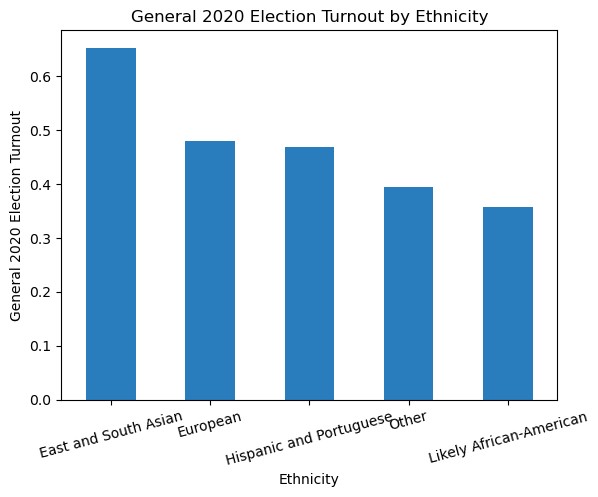

In [7]:
df_GA_ethnicgroup = young_voters.select(['EthnicGroups_EthnicGroup1Desc', 'General_2020'])

df_GA_ethnicgroup = df_GA_ethnicgroup.na.fill(value='N',subset=['General_2020'])
df_GA_ethnicgroup = df_GA_ethnicgroup.withColumn('General_2020', translate('General_2020', 'Y', '1'))
df_GA_ethnicgroup = df_GA_ethnicgroup.withColumn('General_2020', translate('General_2020', 'N', '0'))
df_GA_ethnicgroup = df_GA_ethnicgroup.withColumn('General_2020', col('General_2020').cast('int'))

df_GA_ethnicgroup_turnout = df_GA_ethnicgroup.groupBy('EthnicGroups_EthnicGroup1Desc')\
    .agg(count('EthnicGroups_EthnicGroup1Desc').alias('ethnicgroup_count'),
         avg('General_2020').alias('general_2020_turnout'))\
    .orderBy(col('general_2020_turnout').desc()).drop('ethnicgroup_count').dropna()

df_GA_ethnicgroup_turnout = df_GA_ethnicgroup_turnout.toPandas()
plt.rcParams.update({'font.size': 10})
df_GA_ethnicgroup_turnout.plot.bar(x = 'EthnicGroups_EthnicGroup1Desc', y = 'general_2020_turnout', 
                               xlabel = 'Ethnicity', ylabel = 'General 2020 Election Turnout', 
                               title = 'General 2020 Election Turnout by Ethnicity', rot = 15, legend = False, color = '#2A7DBD')

Text(0.5, 1.0, 'Ethnic Distribution of Georgia Voters who Specified Ethnicity')

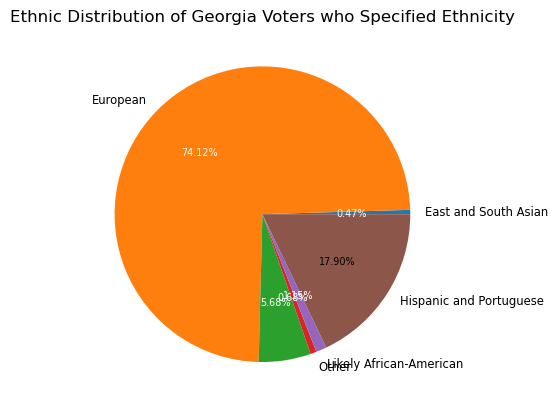

In [8]:
ga_group = young_voters.select('EthnicGroups_EthnicGroup1Desc').groupby('EthnicGroups_EthnicGroup1Desc').count()
ethga = [row[0] for row in ga_group.select('EthnicGroups_EthnicGroup1Desc').collect()]
numga = [row[0] for row in ga_group.select('count').collect()]


fig, ax = plt.subplots()
patches, texts, autotexts = ax.pie(numga, labels=ethga,
                                           autopct='%.2f%%',
                                           textprops={'size': 'smaller'})

plt.setp(autotexts, size='x-small')
autotexts[0].set_color('white')
autotexts[1].set_color('white')
autotexts[2].set_color('white')
autotexts[3].set_color('white')
autotexts[4].set_color('white')
plt.title('Ethnic Distribution of Georgia Voters who Specified Ethnicity')

#### What are some of the disparities in interests/lifestyle (leisure activity, sports, arts, travel etc.) that impact voter turnout?

**Understanding the Impact of Interests and Lifestyles on Voter Turnout**

In the realm of democratic participation, voter turnout remains a crucial metric reflecting the level of civic engagement within a society. However, the factors influencing voter turnout are multifaceted, ranging from demographic characteristics to socio-economic status and, notably, individual interests and lifestyles. This analysis delves into the intersection of interests and voter behavior, specifically exploring how various leisure activities, sports, arts, and travel preferences impact voter turnout.

By examining a dataset encompassing diverse interests/lifestyle categories and corresponding voter participation data, this study aims to uncover patterns and disparities that shed light on the underlying dynamics of civic engagement. Through a detailed examination of count and ratio metrics for each interest column, we gain valuable insights into the leading causes for disparities in voter turnout among individuals of different ethnicities.

This section sets the stage for a comprehensive exploration of how personal passions and recreational pursuits intersect with civic responsibilities, offering valuable implications for electoral outreach strategies, policy advocacy, and community engagement initiatives. By understanding these nuances, stakeholders can develop targeted approaches to enhance democratic participation and foster a more inclusive and informed electorate.

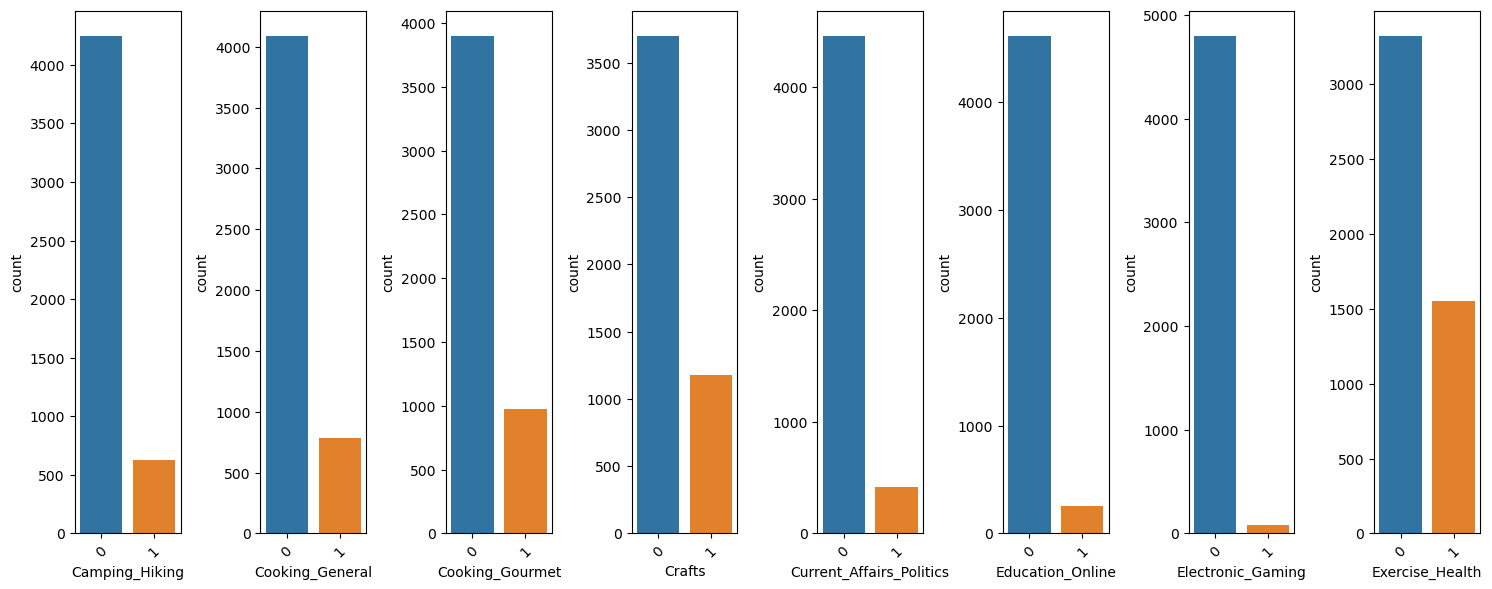

In [23]:
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt
import seaborn as sns

# Rename the actual dataframe columns to match the odd interest column names
rename_map = {
    'CommercialDataLL_Interest_in_Camping_Hiking_In_Household': 'Camping_Hiking',
    'CommercialDataLL_Interest_in_Cooking_General_In_Household': 'Cooking_General',
    'CommercialDataLL_Interest_in_Cooking_Gourmet_In_Household': 'Cooking_Gourmet',
    'CommercialDataLL_Interest_in_Crafts_In_Household': 'Crafts',
    'CommercialDataLL_Interest_in_Current_Affairs_Politics_In_Household': 'Current_Affairs_Politics',
    'CommercialDataLL_Interest_in_Education_Online_In_Household': 'Education_Online',
    'CommercialDataLL_Interest_in_Electronic_Gaming_In_Household': 'Electronic_Gaming',
    'CommercialDataLL_Interest_in_Exercise_Health_In_Household': 'Exercise_Health'
}

# Apply the column renaming to the dataframe
renamed_df = young_voters
for old_name, new_name in rename_map.items():
    renamed_df = renamed_df.withColumnRenamed(old_name, new_name)

# List of interest columns (renamed)
interest_columns = list(rename_map.values())

# Initialize subplots
fig, axs = plt.subplots(1, len(interest_columns), figsize=(15, 6))

# Convert Yes/Null to 1 or 0 for each interest column and plot
for idx, column in enumerate(interest_columns):
    selected_df = renamed_df.withColumn(column, 
                                        when(col(column) == 'Yes', 1)
                                        .when(col(column).isNull(), 0)
                                        .otherwise(0))

    # Remove rows with all NaN values in interest columns
    #selected_df = selected_df.dropna(subset=[column])

    # Convert to Pandas for visualization
    pandas_df = selected_df.toPandas()

    # Plot in the corresponding subplot
    sns.countplot(x=column, data=pandas_df, ax=axs[idx])
    #axs[idx].set_title(f"{column}")
    axs[idx].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Adjust layout and add legend
plt.tight_layout()
plt.show()


We hypothesize that the reduced voter turnout among younger populations may be attributed to their concentration in college campuses, where a lack of awareness about regional laws or competing priorities diminishes their propensity to vote. This theory is supported by observations that younger, non-voting individuals often engage in online electronic gaming and show interest in current affairs, characteristics typical of college students with limited financial resources. This demographic profile aligns with our expectations and suggests that younger voters represent a significant opportunity for increasing electoral participation. Successfully engaging this group through targeted campaigning could unlock substantial gains in voter turnout, leveraging their potential to influence political outcomes significantly.


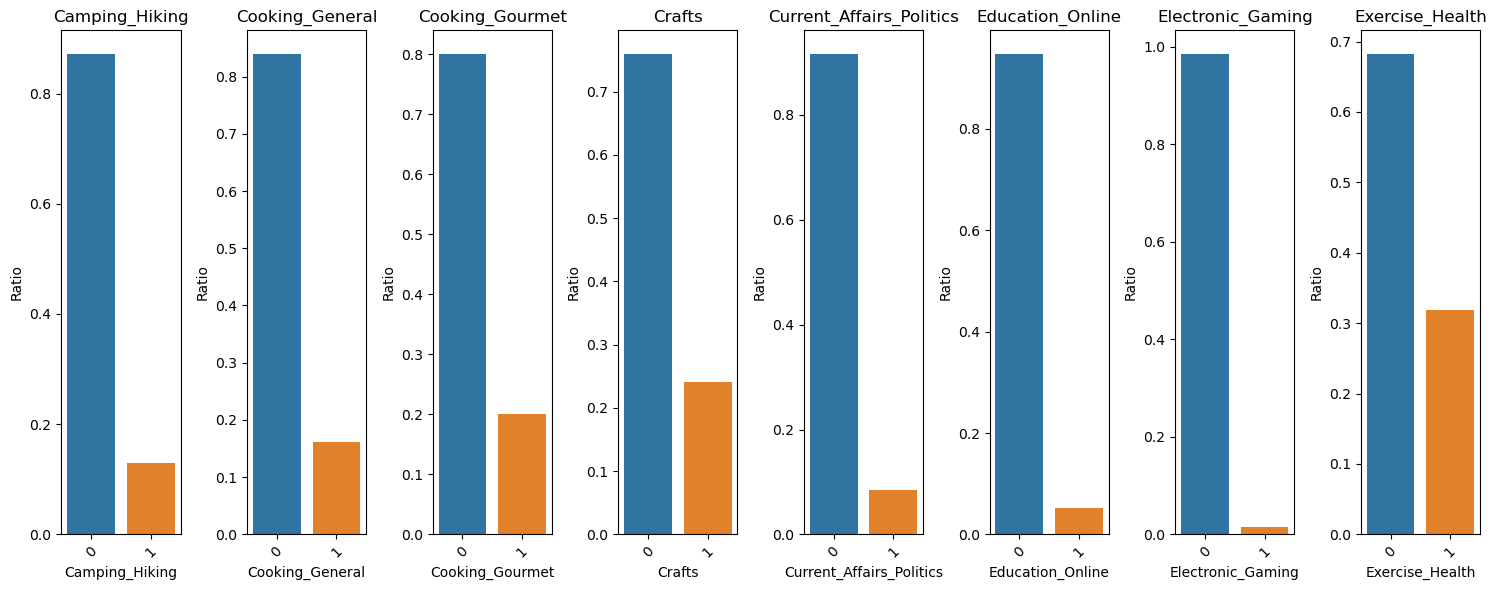

In [24]:
from pyspark.sql.functions import when, col
import matplotlib.pyplot as plt
import seaborn as sns

# Rename the actual dataframe columns to match the odd interest column names
rename_map = {
    'CommercialDataLL_Interest_in_Camping_Hiking_In_Household': 'Camping_Hiking',
    'CommercialDataLL_Interest_in_Cooking_General_In_Household': 'Cooking_General',
    'CommercialDataLL_Interest_in_Cooking_Gourmet_In_Household': 'Cooking_Gourmet',
    'CommercialDataLL_Interest_in_Crafts_In_Household': 'Crafts',
    'CommercialDataLL_Interest_in_Current_Affairs_Politics_In_Household': 'Current_Affairs_Politics',
    'CommercialDataLL_Interest_in_Education_Online_In_Household': 'Education_Online',
    'CommercialDataLL_Interest_in_Electronic_Gaming_In_Household': 'Electronic_Gaming',
    'CommercialDataLL_Interest_in_Exercise_Health_In_Household': 'Exercise_Health'
}

# Apply the column renaming to the dataframe
renamed_df = young_voters
for old_name, new_name in rename_map.items():
    renamed_df = renamed_df.withColumnRenamed(old_name, new_name)

# List of interest columns (renamed)
interest_columns = list(rename_map.values())

# Initialize subplots
fig, axs = plt.subplots(1, len(interest_columns), figsize=(15, 6))

# Convert Yes/Null to 1 or 0 for each interest column and plot the ratio
for idx, column in enumerate(interest_columns):
    selected_df = renamed_df.withColumn(column, 
                                        when(col(column) == 'Yes', 1)
                                        .when(col(column).isNull(), 0)
                                        .otherwise(0))

    # Calculate the ratio of 0 and 1 for the interest column
    ratio_values = selected_df.groupBy(column).count()
    ratio_values = ratio_values.withColumn('Ratio', col('count') / selected_df.count())

    # Convert to Pandas for visualization
    pandas_df = ratio_values.toPandas()

    # Plot the ratio in the corresponding subplot
    sns.barplot(x=column, y='Ratio', data=pandas_df, ax=axs[idx])
    axs[idx].set_title(f"{column}")
    axs[idx].tick_params(axis='x', rotation=45)  # Rotate x-axis labels

# Adjust layout
plt.tight_layout()
plt.show()


In [25]:
from pyspark.sql.functions import when, col
import pandas as pd

# Rename the actual dataframe columns to match the odd interest column names
rename_map = {
    'CommercialDataLL_Interest_in_Camping_Hiking_In_Household': 'Camping_Hiking',
    'CommercialDataLL_Interest_in_Cooking_General_In_Household': 'Cooking_General',
    'CommercialDataLL_Interest_in_Cooking_Gourmet_In_Household': 'Cooking_Gourmet',
    'CommercialDataLL_Interest_in_Crafts_In_Household': 'Crafts',
    'CommercialDataLL_Interest_in_Current_Affairs_Politics_In_Household': 'Current_Affairs_Politics',
    'CommercialDataLL_Interest_in_Education_Online_In_Household': 'Education_Online',
    'CommercialDataLL_Interest_in_Electronic_Gaming_In_Household': 'Electronic_Gaming',
    'CommercialDataLL_Interest_in_Exercise_Health_In_Household': 'Exercise_Health'
}

# Apply the column renaming to the dataframe
renamed_df = young_voters
for old_name, new_name in rename_map.items():
    renamed_df = renamed_df.withColumnRenamed(old_name, new_name)

# List of interest columns (renamed)
interest_columns = list(rename_map.values())

# Create an empty DataFrame to store the results
result_df = pd.DataFrame(columns=['Interest_Column', 'Count_Yes', 'Count_Null', 'Ratio_Yes'])

# Convert Yes/Null to 1 or 0 for each interest column and calculate the count and ratio
for idx, column in enumerate(interest_columns):
    selected_df = renamed_df.withColumn(column, 
                                        when(col(column) == 'Yes', 1)
                                        .when(col(column).isNull(), 0)
                                        .otherwise(0))

    # Calculate the count of Yes and Null values for the interest column
    count_values = selected_df.groupBy(column).count().collect()
    count_yes = next((row['count'] for row in count_values if row[column] == 1), 0)
    count_null = next((row['count'] for row in count_values if row[column] == 0), 0)

    # Calculate the ratio of Yes to Null values for the interest column
    ratio_yes = count_yes / (count_yes + count_null) if count_yes + count_null != 0 else 0

    # Add the results to the DataFrame
    result_df = pd.concat([result_df, pd.DataFrame({'Interest_Column': [column],
                                                    'Count_Yes': [count_yes],
                                                    'Count_Null': [count_null],
                                                    'Ratio_Yes': [ratio_yes]})])

# Print the resulting DataFrame
print("Count and Ratio for each Interest Column:")
print(result_df)

Count and Ratio for each Interest Column:
            Interest_Column Count_Yes Count_Null  Ratio_Yes
0            Camping_Hiking       628       4249   0.128768
0           Cooking_General       786       4091   0.161165
0           Cooking_Gourmet       977       3900   0.200328
0                    Crafts      1176       3701   0.241132
0  Current_Affairs_Politics       413       4464   0.084683
0          Education_Online       258       4619   0.052901
0         Electronic_Gaming        77       4800   0.015788
0           Exercise_Health      1552       3325   0.318228


Based on the collected information about the count and ratio for each interest column, we can analyze potential causes for disparity in voter turnout based on different interests/lifestyles. Here are some observations and insights:

1. **Exercise_Health**: This interest column has the highest ratio of Yes to Null values (0.318), indicating a significant interest among voters. It suggests that individuals who prioritize exercise and health-related activities may be more likely to participate in voting. This could be due to a sense of responsibility and awareness about health policies or community well-being.

2. **Cooking_Gourmet**: Similarly, the interest in gourmet cooking shows a relatively high ratio (0.200). This might imply that individuals with a passion for culinary arts or gastronomy are engaged in civic activities like voting. It could be related to concerns about food policies, cultural representation, or community events related to food.

3. **Crafts and Camping_Hiking**: These interests also show notable ratios (0.241 and 0.129, respectively). It suggests that individuals interested in outdoor activities, nature, and crafts are active in civic engagement. This could be linked to environmental concerns, outdoor recreational policies, or community initiatives related to arts and crafts.

4. **Current_Affairs_Politics**: Surprisingly, the interest in current affairs and politics has a lower ratio (0.085). This might indicate that while individuals have an interest in these topics, it doesn't always translate directly into higher voter turnout. Other factors such as trust in the political system, accessibility to voting, or campaign effectiveness could influence this disparity.

5. **Education_Online and Electronic_Gaming**: These interests have the lowest ratios (0.053 and 0.016, respectively). It suggests that individuals interested in online education or electronic gaming may be less engaged in traditional civic activities like voting. This could be due to various reasons such as demographic differences, generational trends, or perceived priorities.

Overall, these disparities in interests/lifestyles can impact voter turnout by reflecting different levels of civic engagement, awareness of political issues, and community involvement. Understanding these patterns can help tailor outreach strategies, policy messaging, and voter education initiatives to address diverse interests and increase overall participation in elections.

#### How does affluency levels of residential regions impact voter turnout?

In [29]:
area_columns = ['General_2020','County','Residence_Addresses_Latitude',
                  'Residence_Addresses_Longitude','CommercialData_EstimatedHHIncomeAmount','CommercialData_EstimatedAreaMedianHHIncome']
ga_area = ga_samp.select(area_columns)

In [30]:
ga_area = ga_area.withColumnRenamed('General_2020', 'General 2020') \
       .withColumnRenamed('Residence_Addresses_Latitude', "Latitude") \
       .withColumnRenamed('Residence_Addresses_Longitude', "Longitude")\
       .withColumnRenamed("CommercialData_EstimatedHHIncomeAmount", "Household Income") \
       .withColumnRenamed("CommercialData_EstimatedAreaMedianHHIncome", "Median Household Income")

In [31]:
# cast proper column types, fix format
ga_area = ga_area.withColumn("Household Income", regexp_replace(col("Household Income"), "\\$", "").cast("int"))
ga_area = ga_area.withColumn("Median Household Income", regexp_replace(col("Median Household Income"), "\\$", "").cast("int"))
ga_area = ga_area.withColumn('Latitude', col('Latitude').cast('float'))
ga_area = ga_area.withColumn('Longitude', col('Longitude').cast('float'))

In [32]:
null_counts = ga_area.select([count(when(isnull(c), c)).alias(c) for c in ga_area.columns])

# percentage of null values in each column
for column_name in null_counts.columns:
    null_counts = null_counts.withColumn(column_name, round(col(column_name) / ga_area.count(), 3))
    
print("Ratio of Null Values for each Area and Income Column:\n")
print(null_counts.show())

Ratio of Null Values for each Area and Income Column:



+------------+------+--------+---------+----------------+-----------------------+
|General 2020|County|Latitude|Longitude|Household Income|Median Household Income|
+------------+------+--------+---------+----------------+-----------------------+
|        0.31|   0.0|     0.0|      0.0|           0.026|                  0.036|
+------------+------+--------+---------+----------------+-----------------------+

None


In [33]:
ga_area_clean = ga_area.dropna()
ga_area_clean.count()

47823

In [34]:
ga_area_vote = ga_area.na.fill(value='N',subset=['General 2020'])
ga_area_vote = ga_area_vote.withColumn('General 2020', translate('General 2020', 'Y', '1'))
ga_area_vote = ga_area_vote.withColumn('General 2020', translate('General 2020', 'N', '0'))
ga_area_vote = ga_area_vote.withColumn('General 2020', col('General 2020').cast('int'))

In [35]:
# coarsen gridsize for plotting
from pyspark.ml.feature import Bucketizer

min_long = ga_area_vote.agg({"Longitude": "min"}).collect()[0][0]
max_long = ga_area_vote.agg({"Longitude": "max"}).collect()[0][0]
min_lat = ga_area_vote.agg({"Latitude": "min"}).collect()[0][0]
max_lat = ga_area_vote.agg({"Latitude": "max"}).collect()[0][0]

# Generate splits
step = .05
splits_long = list(np.arange(min_long, max_long + step, step))
splits_lat = list(np.arange(min_lat, max_lat + step, step))

bucketizer_long = Bucketizer(splits=splits_long, inputCol="Longitude", outputCol="long_bucket")
bucketizer_lat = Bucketizer(splits=splits_lat, inputCol="Latitude", outputCol="lat_bucket")

ga_area_vote_buck = bucketizer_long.transform(ga_area_vote)
ga_area_vote_buck = bucketizer_lat.transform(ga_area_vote_buck)

In [36]:
from pyspark.ml.feature import OneHotEncoder

encoder_long = OneHotEncoder(inputCols=["long_bucket"], outputCols=["long_bucket_vec"])
ga_area_vote_encoded = encoder_long.fit(ga_area_vote_buck).transform(ga_area_vote_buck)
encoder_lat = OneHotEncoder(inputCols=["lat_bucket"], outputCols=["lat_bucket_vec"])
ga_area_vote_encoded = encoder_lat.fit(ga_area_vote_encoded).transform(ga_area_vote_encoded)

ga_area_vote_encoded.show()

+------------+------+---------+----------+----------------+-----------------------+-----------+----------+---------------+---------------+
|General 2020|County| Latitude| Longitude|Household Income|Median Household Income|long_bucket|lat_bucket|long_bucket_vec| lat_bucket_vec|
+------------+------+---------+----------+----------------+-----------------------+-----------+----------+---------------+---------------+
|           0|ELBERT| 34.21258| -83.02146|            9000|                  37320|       51.0|      77.0|(94,[51],[1.0])|(92,[77],[1.0])|
|           0|ELBERT|34.197884| -83.03613|           46199|                  46199|       51.0|      76.0|(94,[51],[1.0])|(92,[76],[1.0])|
|           1|ELBERT| 34.19424| -83.02547|           60000|                  37320|       51.0|      76.0|(94,[51],[1.0])|(92,[76],[1.0])|
|           0|ELBERT| 34.12452| -83.00016|           43369|                  43369|       51.0|      75.0|(94,[51],[1.0])|(92,[75],[1.0])|
|           1|ELBERT| 34.17

In [37]:
ga_area_vote_pandas = ga_area_vote_encoded.toPandas()

In [38]:
ga_area_turnout = ga_area_vote_pandas.groupby(['long_bucket', 'lat_bucket']).agg({'General 2020': 'mean'}).reset_index()

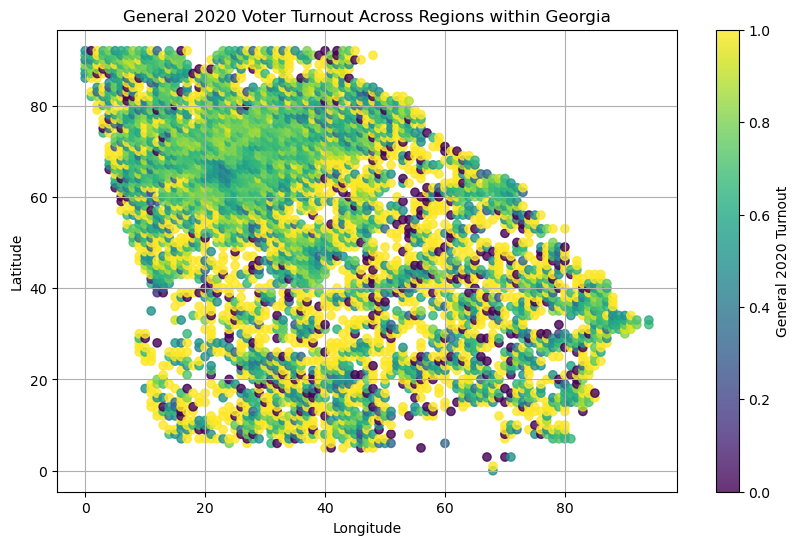

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(data=ga_area_turnout, x='long_bucket', y='lat_bucket', c='General 2020', alpha=0.8)
plt.colorbar(label='General 2020 Turnout')
plt.title('General 2020 Voter Turnout Across Regions within Georgia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

In [40]:
ga_area_pandas = ga_area_clean.toPandas()

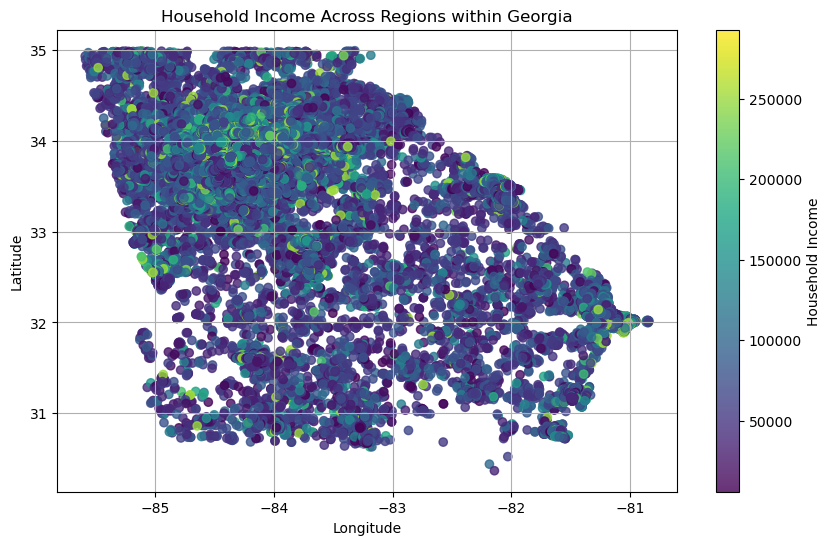

In [41]:
# Plot longitude and latitude with income data
plt.figure(figsize=(10, 6))
plt.scatter(data=ga_area_pandas, x='Longitude', y='Latitude', c='Household Income', alpha=0.8)
plt.colorbar(label='Household Income')
plt.title('Household Income Across Regions within Georgia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

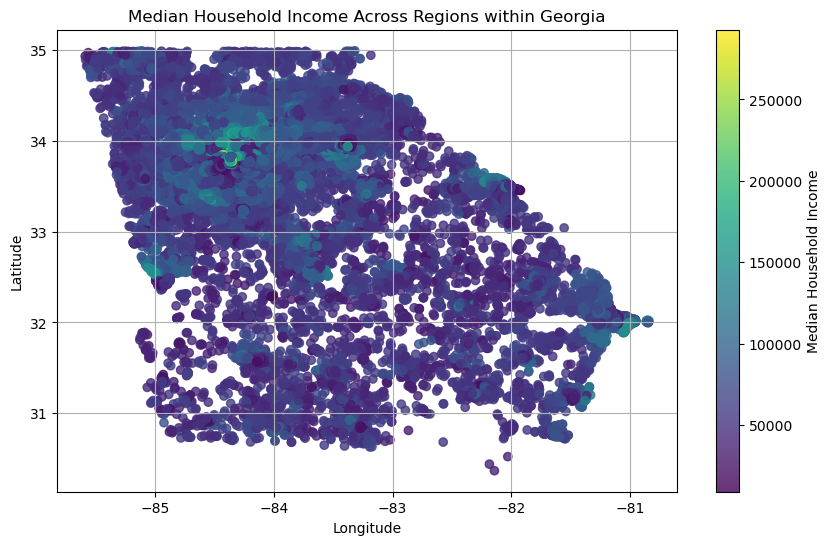

In [42]:
plt.figure(figsize=(10, 6))
plt.scatter(data=ga_area_pandas, x='Longitude', y='Latitude', c='Median Household Income', alpha=0.8)
plt.colorbar(label='Median Household Income')
plt.title('Median Household Income Across Regions within Georgia')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.grid(True)
plt.show()

Central Georgia, particularly the Atlanta area, exhibits higher household incomes compared to the more southern regions of the state. The distribution of data reflects greater density and affluence, with more pronounced and consistent voter registration and activity in these wealthier areas. Notably, pockets of higher income and affluence are also identified in Columbus and Savannah, positioned along Georgia's coastal flanks. In these wealthier, more populous cities, the elevated cost of living and higher incomes correlate with a denser voter base.

Analyzing voter turnout, as detailed in Figure 1 for the General 2020 election, reveals a nuanced picture. In Figure 2, the binary representation of voter turnout, with 0 indicating no turnout and 1 indicating participation, provides insight into regional voting patterns. Intermediate values within this spectrum, calculated for specific areas in grid cells of 0.05 degrees, represent the average turnout. A value approaching 1 suggests high participation in the 2020 election, whereas a value near 0 indicates lower engagement. This analysis shows that affluent regions around Atlanta and Savannah consistently demonstrate higher average voter turnout compared to other areas, which exhibit greater variability in their data, alternating between extremes of 0 and 1. This variance points to a possible data scarcity in less affluent, less densely populated regions.

In summary, affluent areas tend to have higher voter turnout, likely influenced by both higher population density and greater affluence. This pattern underscores the interconnectedness of socioeconomic status, population distribution, and electoral participation in Georgia


**Additional Data Exploratory**

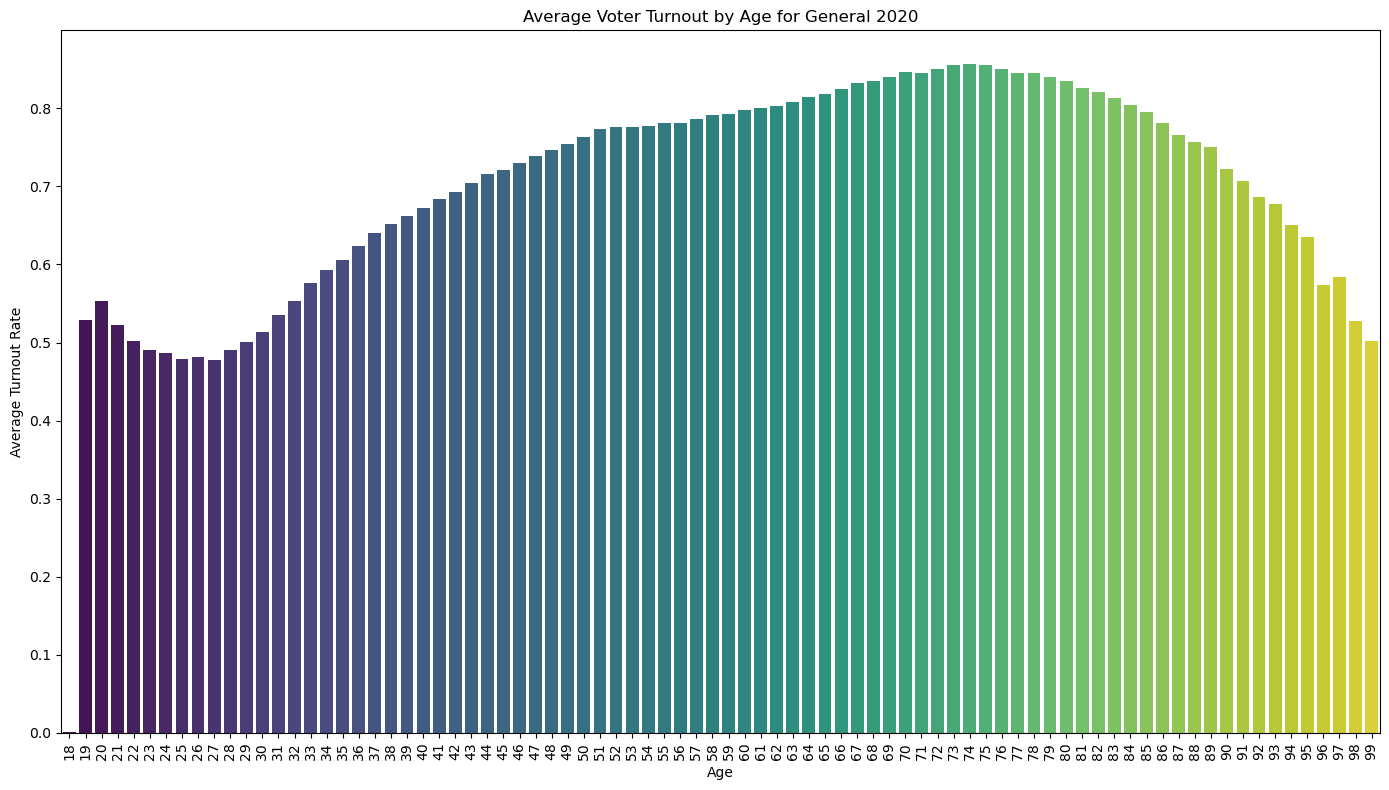

In [14]:
relevant_data = ga_data.select(
    "Voters_Age",
    "Voters_Gender",
    "Ethnic_Description",
    "CommercialData_EstimatedHHIncome",
    "General_2020", "General_2016", "General_2012", # Add or remove years as needed
)

turnout_by_age = relevant_data.groupBy("Voters_Age").agg(
    avg("General_2020").alias("Average_Turnout_2020")
)

converted_data = relevant_data.withColumn(
    "Voted_2020",
    when(col("General_2020") == 'Y', 1).otherwise(0)
)

filtered_data = converted_data.filter(col("Voters_Age") != 100)

turnout_by_age = filtered_data.groupBy("Voters_Age").agg(
    avg("Voted_2020").alias("Average_Turnout_2020")
).orderBy("Voters_Age")

turnout_by_age_pd = turnout_by_age.toPandas()

plt.figure(figsize=(14, 8))
sns.barplot(x="Voters_Age", y="Average_Turnout_2020", data=turnout_by_age_pd, palette="viridis")
plt.title("Average Voter Turnout by Age for General 2020")
plt.xlabel("Age")
plt.ylabel("Average Turnout Rate")
plt.xticks(rotation=90)  
plt.tight_layout()
plt.show()

In Georgia, voter turnout varies significantly with factors like age, gender, and income, showing lower participation among young people, lower-income individuals, and men. These disparities are linked to socioeconomic differences, reduced political engagement among marginalized groups, and barriers such as strict ID laws and limited polling sites. The historical exclusion of these groups from political discourse may also lead to disenchantment with voting. Addressing this requires a comprehensive strategy to improve civic education, broaden access to voting, and remove structural obstacles. Enhancing inclusivity and fairness in the electoral system is vital for ensuring every Georgian can vote and impact their community and state's future.

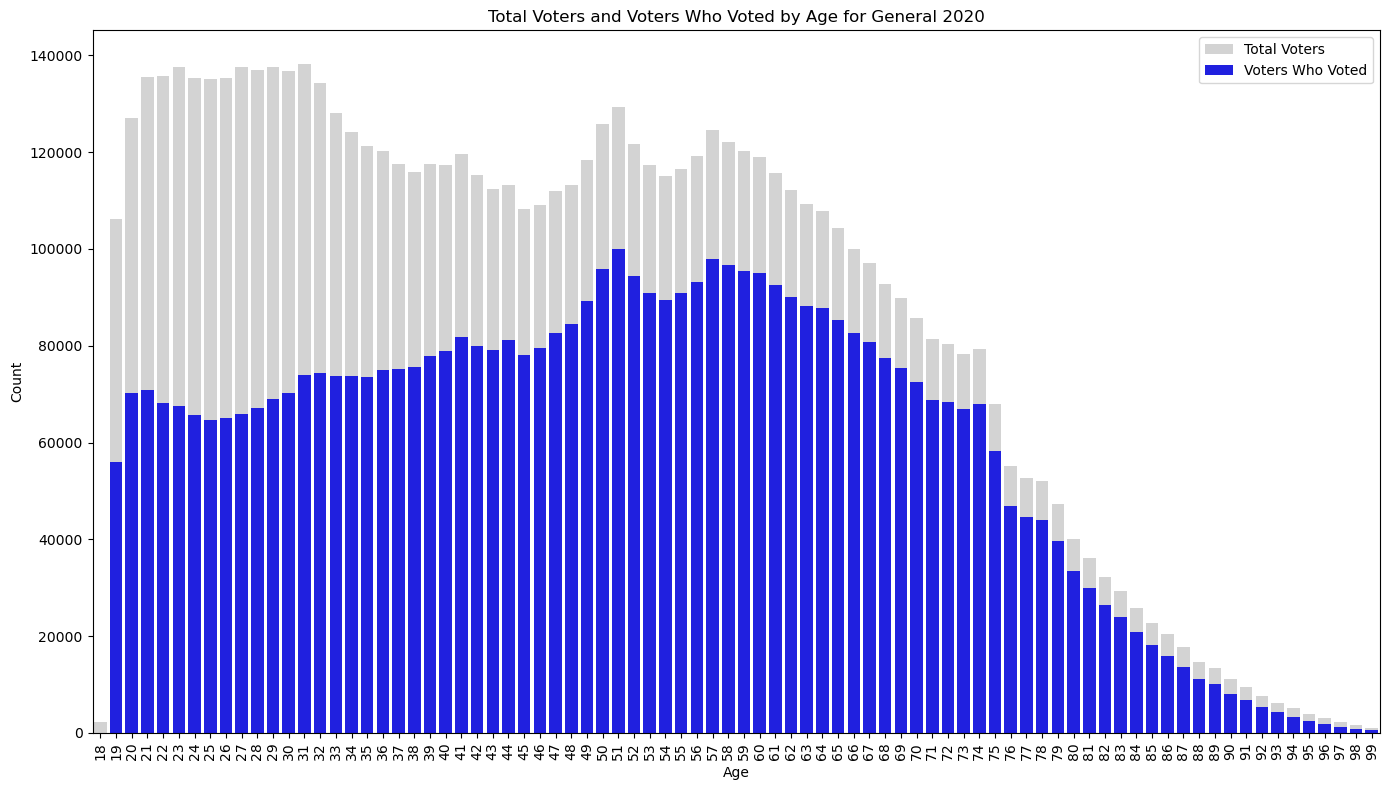

In [15]:
filtered_data = converted_data.filter(col("Voters_Age") != 100)

total_and_voted_by_age = filtered_data.groupBy("Voters_Age").agg(
    count("*").alias("Total_Voters"),
    sum("Voted_2020").alias("Voters_Who_Voted")
).orderBy("Voters_Age")

total_and_voted_by_age_pd = total_and_voted_by_age.toPandas()

plt.figure(figsize=(14, 8))
sns.barplot(x="Voters_Age", y="Total_Voters", data=total_and_voted_by_age_pd, color='lightgrey', label='Total Voters')
sns.barplot(x="Voters_Age", y="Voters_Who_Voted", data=total_and_voted_by_age_pd, color='blue', label='Voters Who Voted')
plt.legend()
plt.title("Total Voters and Voters Who Voted by Age for General 2020")
plt.xlabel("Age")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The analysis of the provided data indicates a discernible pattern of lower voter turnout among younger populations compared to older demographics. Recognizing that multiple factors likely contribute to this trend, we propose to undertake an exploratory analysis to identify the key determinants behind this phenomenon. Focusing on the demographic segment exhibiting the most significant disparity between actual voters and the eligible voting population will offer critical insights into strategies for enhancing voter participation. Notably, as individuals age, the gap between those who vote and those who abstain narrows, suggesting age-related shifts in voting behavior.


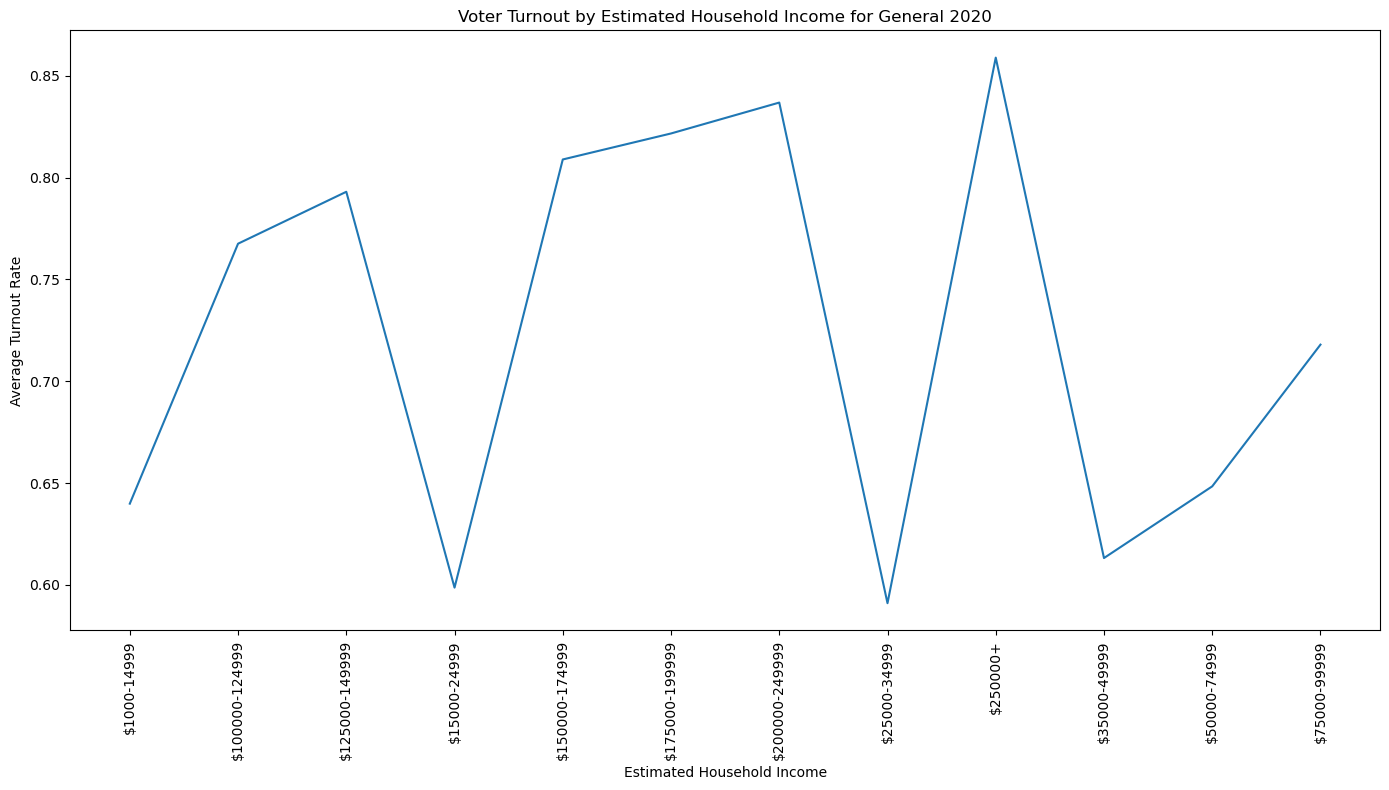

In [16]:
turnout_by_gender = converted_data.groupBy("Voters_Gender").agg(
    avg("Voted_2020").alias("Average_Turnout_By_Gender")
)

turnout_by_gender_pd = turnout_by_gender.toPandas()

income_turnout_relationship = converted_data.groupBy("CommercialData_EstimatedHHIncome").agg(
    avg("Voted_2020").alias("Average_Turnout_By_Income")
).orderBy("CommercialData_EstimatedHHIncome")

income_turnout_relationship_pd = income_turnout_relationship.toPandas()

plt.figure(figsize=(14, 8))
sns.lineplot(x="CommercialData_EstimatedHHIncome", y="Average_Turnout_By_Income", data=income_turnout_relationship_pd)
plt.title("Voter Turnout by Estimated Household Income for General 2020")
plt.xlabel("Estimated Household Income")
plt.ylabel("Average Turnout Rate")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Further investigation into trends revealed that younger voters, who also tend to fall into lower income brackets, show markedly lower turnout rates compared to wealthier counterparts. This disparity is hypothesized to stem from differing priorities and concerns among these groups, particularly regarding taxation policies. Wealthier individuals might be more motivated to vote due to direct financial implications, such as tax legislation, whereas those with lower incomes may prioritize immediate life challenges over political engagement. Identifying and addressing these underlying factors is crucial for developing targeted strategies to increase voter turnout, especially among demographics where the potential for impact is greatest.

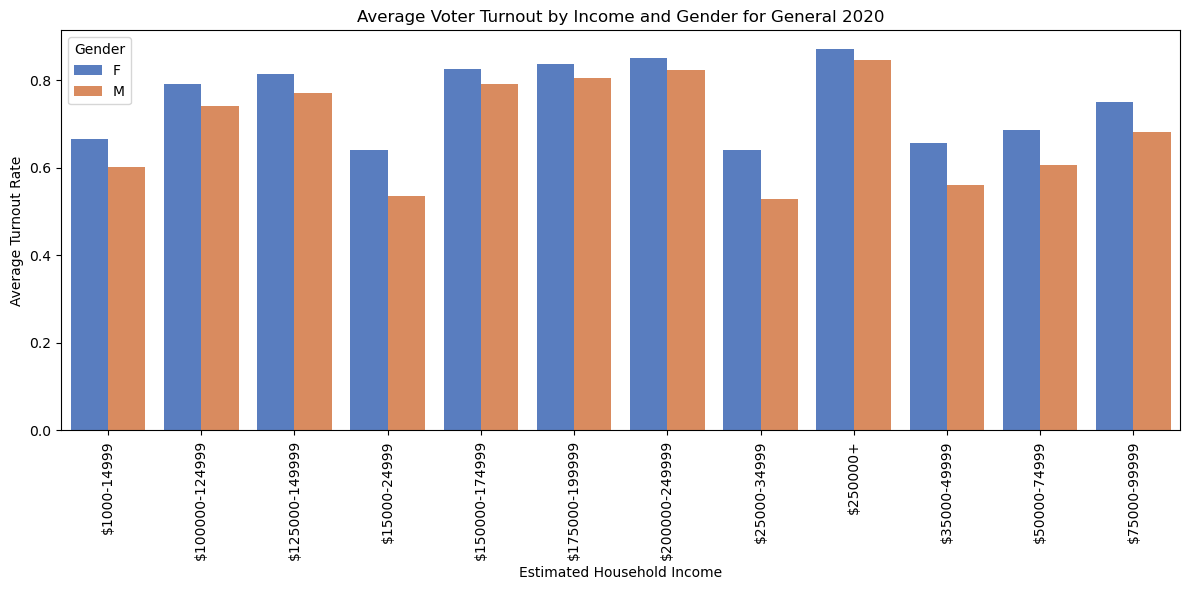

In [17]:
turnout_by_income_gender = converted_data.groupBy("CommercialData_EstimatedHHIncome", "Voters_Gender").agg(
    avg("Voted_2020").alias("Average_Turnout_By_Income_Gender")
).orderBy("CommercialData_EstimatedHHIncome", "Voters_Gender")

turnout_by_income_gender_pd = turnout_by_income_gender.toPandas()

# Plotting the relationship between income, gender, and voter turnout
plt.figure(figsize=(12, 6))
sns.barplot(
    x="CommercialData_EstimatedHHIncome",
    y="Average_Turnout_By_Income_Gender",
    hue="Voters_Gender",
    data=turnout_by_income_gender_pd,
    palette="muted"
)
plt.title("Average Voter Turnout by Income and Gender for General 2020")
plt.xlabel("Estimated Household Income")
plt.ylabel("Average Turnout Rate")
plt.xticks(rotation=90)
plt.tight_layout()  # Adjust layout to make room for the x-axis labels
plt.legend(title='Gender')
plt.show()

In addition, we decided to examine the differences in voter turnout by gender compared to income level. As shown in the plot above, in every income cohort the female population has a higher voter turnout than the male population. We believe discovering the potential factors causing females to have a higher voter turnout ratio would allow us to uncover the necessary actions that must be taken in order to increase male voter turnout.

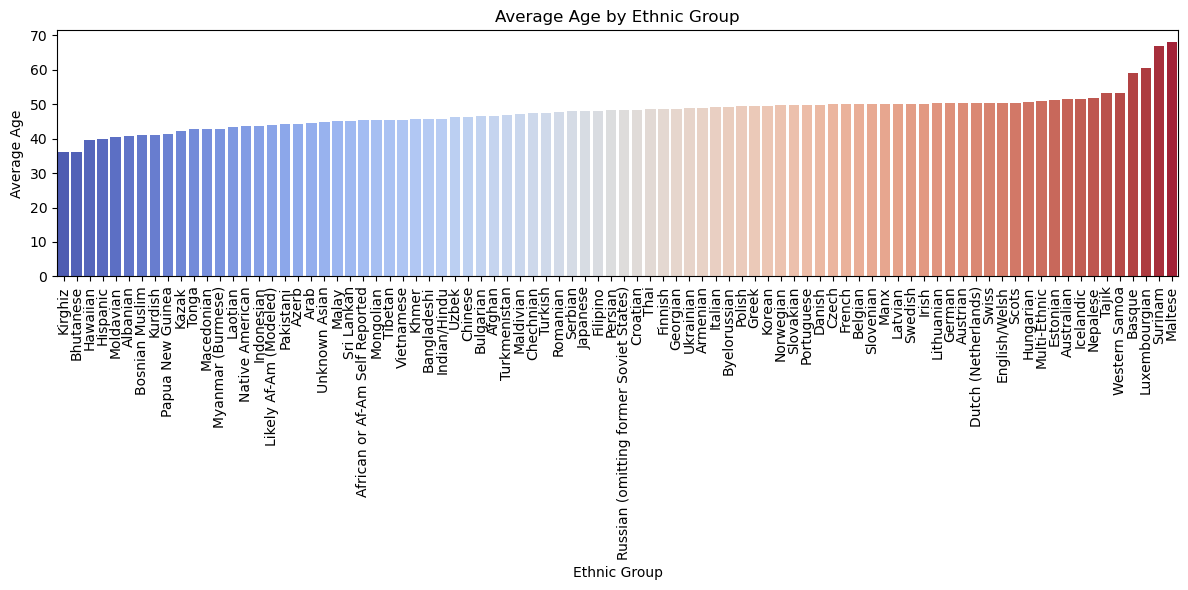

In [22]:
avg_age_by_ethnicity = ga_data.groupBy("Ethnic_Description").agg(
    avg("Voters_Age").alias("Average_Age")
).orderBy("Average_Age")

avg_age_by_ethnicity_pd = avg_age_by_ethnicity.toPandas()

plt.figure(figsize=(12, 6))
sns.barplot(x="Ethnic_Description", y="Average_Age", data=avg_age_by_ethnicity_pd, palette="coolwarm")
plt.title("Average Age by Ethnic Group")
plt.xlabel("Ethnic Group")
plt.ylabel("Average Age")
plt.xticks(rotation=90)  
plt.tight_layout() 
plt.show()

Analyzing voter turnout data among younger demographics reveals complexities beyond initial observations. While it appears that youth participation is low and white individuals vote in disproportionately high numbers relative to their population share, this analysis may not capture the full picture. Further investigation is warranted.

Upon expanding our analysis, we observed that certain ethnic communities, which are generally older, mirror the previously identified trend of higher voter turnout with age. However, this correlation diminishes among younger ethnic groups, hinting at potential influences of socioeconomic factors, such as average household income, on voting behavior.

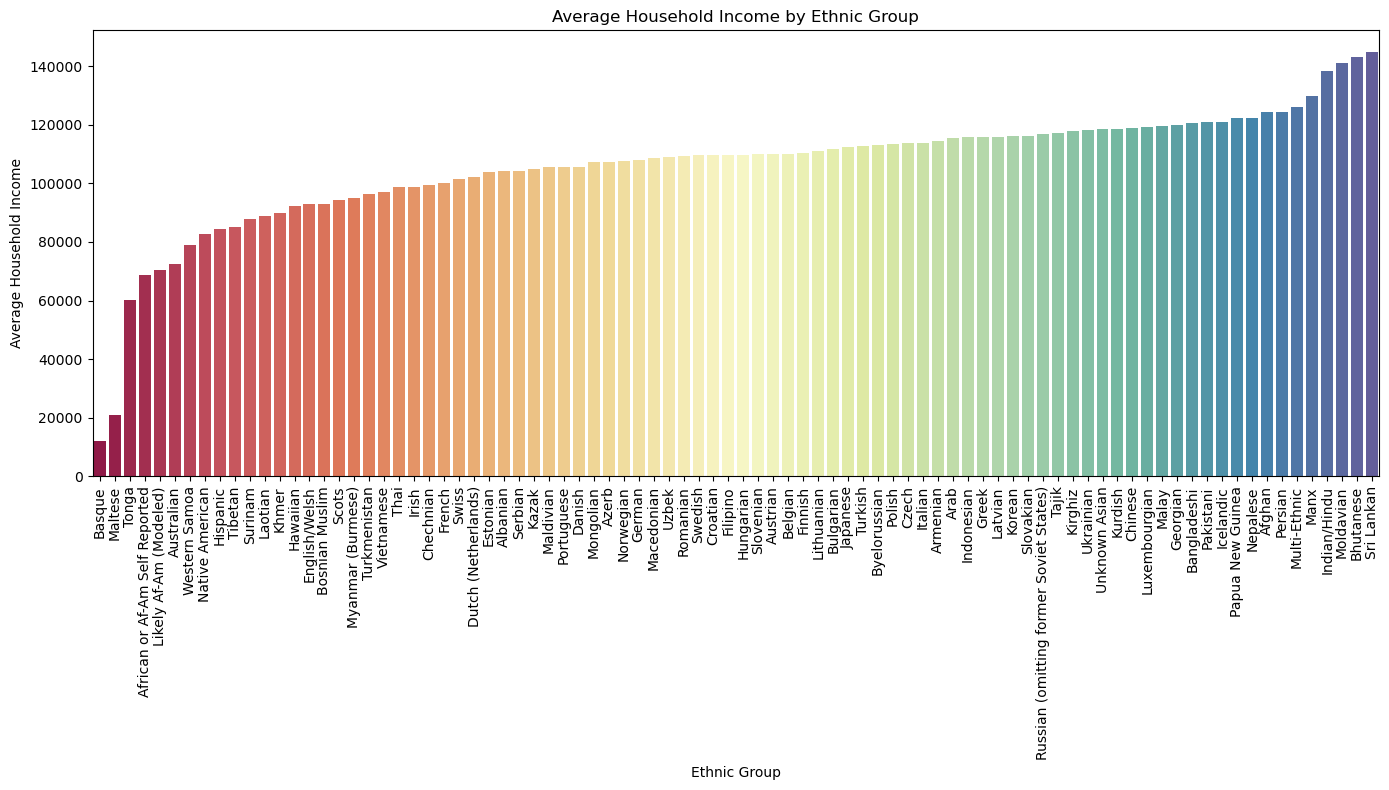

In [24]:
ga_data = ga_data.withColumn(
    "Cleaned_Income",
    regexp_replace(col("CommercialData_EstimatedHHIncomeAmount"), "[\\$,]", "").cast("integer")
)
income_by_ethnicity = ga_data.groupBy("Ethnic_Description").agg(
    avg("Cleaned_Income").alias("Average_Income")
).orderBy("Ethnic_Description")
income_by_ethnicity_pd = income_by_ethnicity.toPandas()
income_by_ethnicity_pd = income_by_ethnicity_pd.dropna(subset=["Average_Income"])
income_by_ethnicity_pd_sorted = income_by_ethnicity_pd.sort_values(by="Average_Income")
plt.figure(figsize=(14, 8))
barplot = sns.barplot(
    x="Ethnic_Description",
    y="Average_Income",
    data=income_by_ethnicity_pd_sorted,
    palette='Spectral'
)
plt.xticks(rotation=90)
plt.xlabel("Ethnic Group")
plt.ylabel("Average Household Income")
plt.title("Average Household Income by Ethnic Group")
plt.tight_layout()
plt.show()

When comparing ethnic groups to average household income, the data did not align as anticipated. Older groups with higher turnout rates did not necessarily correspond to those with the highest income levels. This discrepancy suggests that income alone may not be a definitive factor in predicting voter turnout across different communities. Given the diversity within smaller groups, this finding challenges the assumption that higher income correlates directly with higher electoral participation, indicating that further exploratory analysis is required to uncover more nuanced relationships within the data.



### Methods

#### PySpark

We use PySpark and initialize a Spark Session for any computationally demanding steps, like reading in large amounts of data, One Hot Encoding, etc. We also use random sampling for easier and efficient computing, yet maintain representative results. This is especially useful for plotting and making processing steps faster and more efficient.


#### Logistic Regression

Logistic regression is helpful when we have a binary outcome. It is also helpful when predicting probability of such an outcome. We will model voter turnout, a binary variable of Yes/No, with a **logistic regression model** based on the preliminary findings.

##### Modeling

***A logistic regression model with lifestyle interests as predictors resulted in a AUC ROC metric of 57%.***

In [6]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Define the "Voters_Turnout" column based on "General_2020"
model_data = young_voters.withColumn(
    "Voters_Turnout",
    F.when(F.col("General_2020") == 'Y', 1).otherwise(0)
)

# Define interest columns and convert Yes/Null to 1 or 0
interest_columns = [
    'CommercialDataLL_Interest_in_Boating_Sailing_In_Household',
    'CommercialDataLL_Interest_in_Camping_Hiking_In_Household',
    'CommercialDataLL_Interest_in_Cooking_General_In_Household',
    'CommercialDataLL_Interest_in_Cooking_Gourmet_In_Household',
    'CommercialDataLL_Interest_in_Crafts_In_Household',
    'CommercialDataLL_Interest_in_Current_Affairs_Politics_In_Household',
    'CommercialDataLL_Interest_in_Education_Online_In_Household',
    'CommercialDataLL_Interest_in_Electronic_Gaming_In_Household',
    'CommercialDataLL_Interest_in_Exercise_Aerobic_In_Household',
    'CommercialDataLL_Interest_in_Exercise_Health_In_Household',
    'CommercialDataLL_Interest_in_Exercise_Running_Jogging_In_Household',
]

for column in interest_columns:
    model_data = model_data.withColumn(
        column,
        F.when(F.col(column) == 'Yes', 1).otherwise(0)
    )

# Select columns related to interests/lifestyle and voter turnout
selected_columns = interest_columns + ['Voters_Turnout']

# Filter the dataframe to select only the relevant columns
selected_df = model_data.select(selected_columns)

# Drop any rows with null values in the selected columns
selected_df = selected_df.dropna()

# Define the feature vector assembler
assembler = VectorAssembler(inputCols=interest_columns, outputCol='features')

# Define the logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='Voters_Turnout')

# Create a pipeline for data preprocessing and model training
pipeline = Pipeline(stages=[assembler, lr])

# Split the data into training and testing sets (80% training, 20% testing)
train_data, test_data = selected_df.randomSplit([0.8, 0.2], seed=42)

# Fit the pipeline to the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='Voters_Turnout')
auc = evaluator.evaluate(predictions)

# Print the Area Under ROC Curve (AUC) score
print(f"AUC: {auc}")

# Show sample predictions and actual values
predictions.select('Voters_Turnout', 'prediction', 'probability').show(10, truncate=False)

# Calculate confusion matrix
conf_matrix = predictions.groupBy('Voters_Turnout', 'prediction').count()
conf_matrix.show()

AUC: 0.5741157450899
+--------------+----------+---------------------------------------+
|Voters_Turnout|prediction|probability                            |
+--------------+----------+---------------------------------------+
|0             |0.0       |[0.5686001697865739,0.4313998302134261]|
|0             |0.0       |[0.5686001697865739,0.4313998302134261]|
|0             |0.0       |[0.5686001697865739,0.4313998302134261]|
|0             |0.0       |[0.5686001697865739,0.4313998302134261]|
|0             |0.0       |[0.5686001697865739,0.4313998302134261]|
|0             |0.0       |[0.5686001697865739,0.4313998302134261]|
|0             |0.0       |[0.5686001697865739,0.4313998302134261]|
|0             |0.0       |[0.5686001697865739,0.4313998302134261]|
|0             |0.0       |[0.5686001697865739,0.4313998302134261]|
|0             |0.0       |[0.5686001697865739,0.4313998302134261]|
+--------------+----------+---------------------------------------+
only showing top 10 rows

+

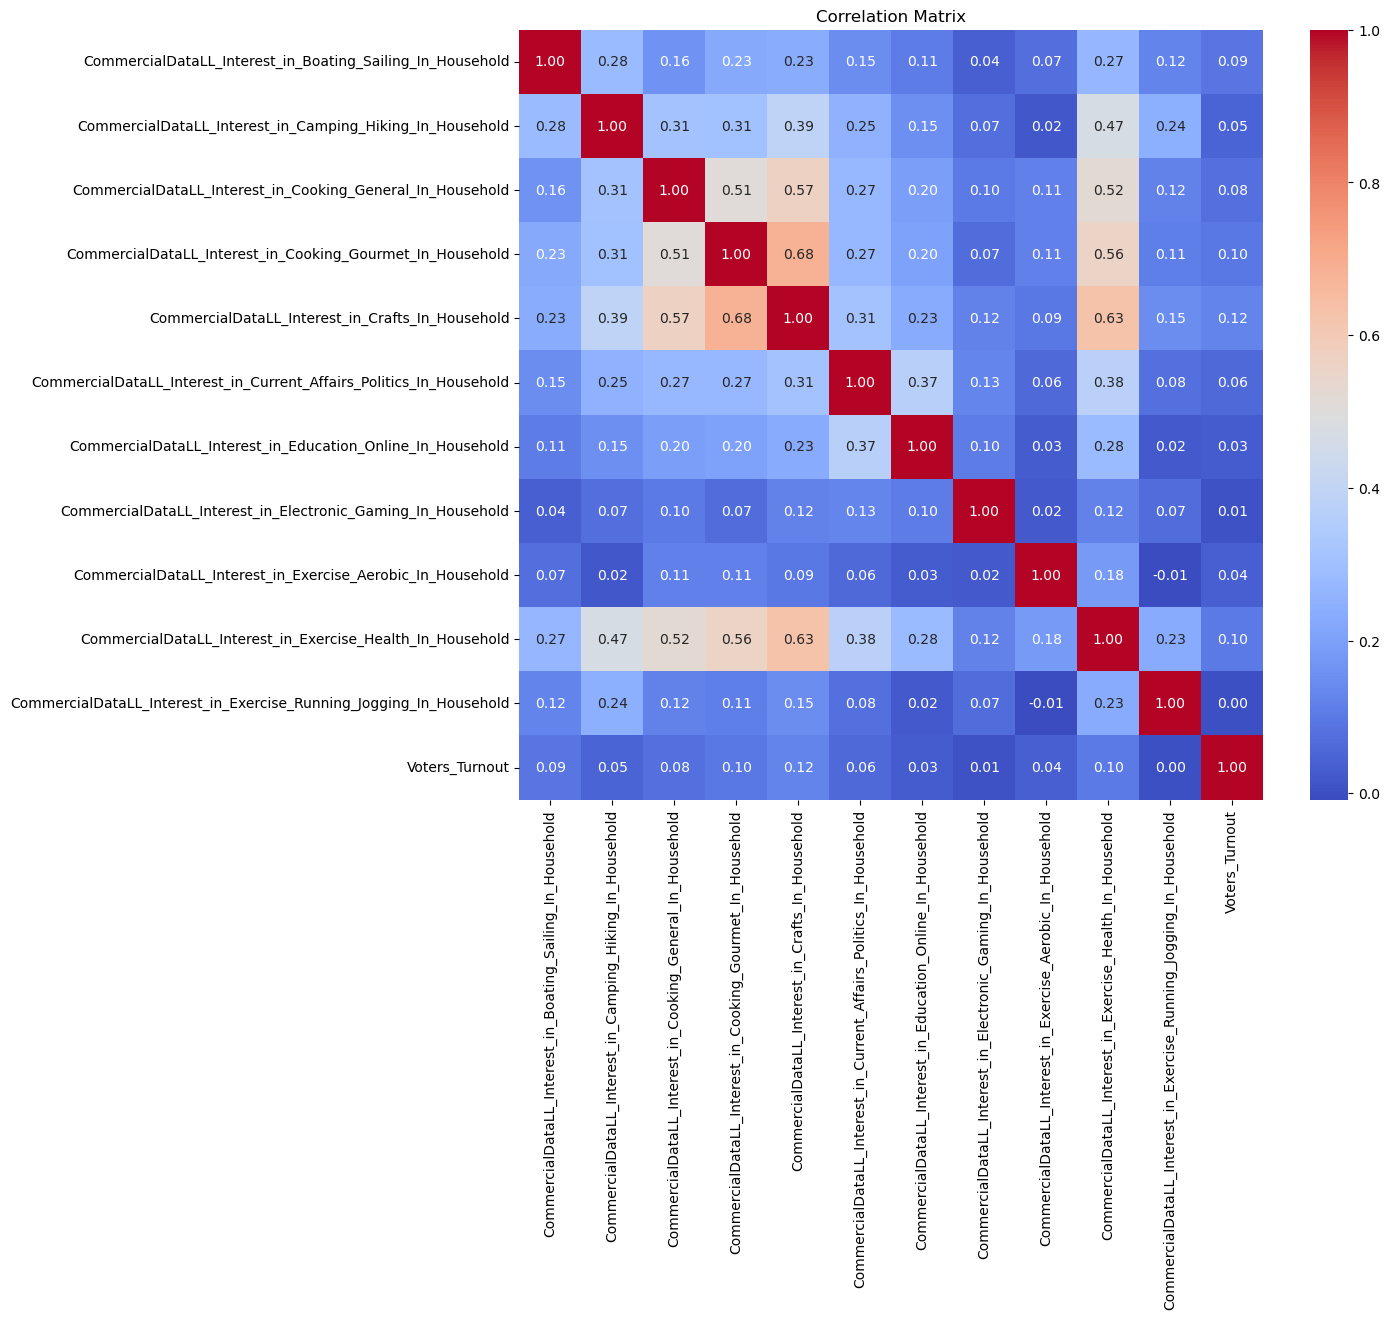

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate correlation matrix
correlation_matrix = selected_df.toPandas().corr()

# Plot the correlation matrix using Seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


***When we consider a logistic regression model with age, gender, and household income as predictors, the AUC ROC is 58.4%.***

In [8]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Define the "Voters_Turnout" column based on "General_2020"
model_data = young_voters.withColumn(
    "Voters_Turnout",
    F.when(F.col("General_2020") == 'Y', 1).otherwise(0)
)


# Remove the dollar sign and cast the column to integer
model_data = model_data.withColumn(
    "CommercialData_EstimatedHHIncomeAmount",
    F.col("CommercialData_EstimatedHHIncomeAmount").substr(2, 100).cast("integer")
)

# Define interest columns and convert Yes/Null to 1 or 0
interest_columns = [
    "Voters_Age",
    "Voters_Gender",
    "CommercialData_EstimatedHHIncomeAmount"
]

for column in interest_columns:
    if column == "Voters_Gender":
        model_data = model_data.withColumn(
            column,
            F.when(F.col(column) == 'M', 1).otherwise(0)
        )

# Select columns related to interests/lifestyle and voter turnout
selected_columns = interest_columns + ['Voters_Turnout']

# Filter the dataframe to select only the relevant columns
selected_df = model_data.select(selected_columns)

# Drop any rows with null values in the selected columns
selected_df = selected_df.dropna()

# Define the feature vector assembler
assembler = VectorAssembler(inputCols=interest_columns, outputCol='features')

# Define the logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='Voters_Turnout')

# Create a pipeline for data preprocessing and model training
pipeline = Pipeline(stages=[assembler, lr])

# Split the data into training and testing sets (80% training, 20% testing)
train_data, test_data = selected_df.randomSplit([0.8, 0.2], seed=42)

# Fit the pipeline to the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='Voters_Turnout')
auc = evaluator.evaluate(predictions)

# Print the Area Under ROC Curve (AUC) score
print(f"AUC: {auc}")

# Show sample predictions and actual values
predictions.select('Voters_Turnout', 'prediction', 'probability').show(10, truncate=False)

# Calculate confusion matrix
conf_matrix = predictions.groupBy('Voters_Turnout', 'prediction').count()
conf_matrix.show()

AUC: 0.5840124184295363
+--------------+----------+----------------------------------------+
|Voters_Turnout|prediction|probability                             |
+--------------+----------+----------------------------------------+
|0             |0.0       |[0.5471831932097083,0.4528168067902917] |
|1             |0.0       |[0.6020943574968359,0.39790564250316407]|
|1             |0.0       |[0.6020943574968359,0.39790564250316407]|
|1             |0.0       |[0.5938344326074194,0.4061655673925806] |
|0             |0.0       |[0.5821817663344296,0.41781823366557036]|
|1             |0.0       |[0.58050925997692,0.41949074002307996]  |
|1             |0.0       |[0.5518236290359809,0.4481763709640191] |
|0             |0.0       |[0.5484222110351685,0.4515777889648315] |
|0             |0.0       |[0.5418927058341647,0.4581072941658353] |
|1             |0.0       |[0.5404935247922646,0.45950647520773535]|
+--------------+----------+----------------------------------------+
only showi

***If we combine lifestyle interests, age, gender, and household income as predictors, we achieve a AUC ROC of 61.2%***

In [9]:
from pyspark.sql import functions as F
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define the "Voters_Turnout" column based on "General_2020"
model_data = young_voters.withColumn(
    "Voters_Turnout",
    F.when(F.col("General_2020") == 'Y', 1).otherwise(0)
)

# Remove the dollar sign and cast the column to integer for CommercialData_EstimatedHHIncomeAmount
model_data = model_data.withColumn(
    "CommercialData_EstimatedHHIncomeAmount",
    F.col("CommercialData_EstimatedHHIncomeAmount").substr(2, 100).cast("integer")
)

# Define interest columns and convert Yes/Null to 1 or 0
interest_columns_1 = [
    'CommercialDataLL_Interest_in_Boating_Sailing_In_Household',
    'CommercialDataLL_Interest_in_Camping_Hiking_In_Household',
    'CommercialDataLL_Interest_in_Cooking_General_In_Household',
    'CommercialDataLL_Interest_in_Cooking_Gourmet_In_Household',
    'CommercialDataLL_Interest_in_Crafts_In_Household',
    'CommercialDataLL_Interest_in_Current_Affairs_Politics_In_Household',
    'CommercialDataLL_Interest_in_Education_Online_In_Household',
    'CommercialDataLL_Interest_in_Electronic_Gaming_In_Household',
    'CommercialDataLL_Interest_in_Exercise_Aerobic_In_Household',
    'CommercialDataLL_Interest_in_Exercise_Health_In_Household',
    'CommercialDataLL_Interest_in_Exercise_Running_Jogging_In_Household',
]

for column in interest_columns_1:
    model_data = model_data.withColumn(
        column,
        F.when(F.col(column) == 'Yes', 1).otherwise(0)
    )

# Define interest columns for the second model
interest_columns_2 = [
    "Voters_Age",
    "Voters_Gender",
    "CommercialData_EstimatedHHIncomeAmount"
]

# Transform Voters_Gender in interest_columns_2
for column in interest_columns_2:
    if column == "Voters_Gender":
        model_data = model_data.withColumn(
            column,
            F.when(F.col(column) == 'M', 1).otherwise(0)
        )

# Select all relevant interest columns
all_interest_columns = interest_columns_1 + interest_columns_2

# Select columns related to interests/lifestyle and voter turnout
selected_columns = all_interest_columns + ['Voters_Turnout']

# Filter the dataframe to select only the relevant columns
selected_df = model_data.select(selected_columns)

# Drop any rows with null values in the selected columns
selected_df = selected_df.dropna()

# Define the feature vector assembler
assembler = VectorAssembler(inputCols=all_interest_columns, outputCol='features')

# Define the logistic regression model
lr = LogisticRegression(featuresCol='features', labelCol='Voters_Turnout')

# Create a pipeline for data preprocessing and model training
pipeline = Pipeline(stages=[assembler, lr])

# Split the data into training and testing sets (80% training, 20% testing)
train_data, test_data = selected_df.randomSplit([0.8, 0.2], seed=42)

# Fit the pipeline to the training data
model = pipeline.fit(train_data)

# Make predictions on the test data
predictions = model.transform(test_data)

# Evaluate the model using BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='Voters_Turnout')
auc = evaluator.evaluate(predictions)

# Print the Area Under ROC Curve (AUC) score
print(f"AUC: {auc}")

# Show sample predictions and actual values
predictions.select('Voters_Turnout', 'prediction', 'probability').show(10, truncate=False)

# Calculate confusion matrix
conf_matrix = predictions.groupBy('Voters_Turnout', 'prediction').count()
conf_matrix.show()

AUC: 0.6122341276187429
+--------------+----------+----------------------------------------+
|Voters_Turnout|prediction|probability                             |
+--------------+----------+----------------------------------------+
|0             |0.0       |[0.574453957819783,0.42554604218021697] |
|1             |0.0       |[0.6219665950974653,0.3780334049025347] |
|0             |0.0       |[0.6205794936277979,0.37942050637220215]|
|0             |0.0       |[0.6066032772438912,0.3933967227561088] |
|0             |0.0       |[0.6009621189808567,0.3990378810191433] |
|0             |0.0       |[0.5878447267220074,0.4121552732779926] |
|1             |0.0       |[0.5699953765989453,0.4300046234010547] |
|0             |0.0       |[0.569545948381441,0.430454051618559]   |
|0             |0.0       |[0.5690154467951123,0.4309845532048877] |
|0             |0.0       |[0.5607999997703373,0.43920000022966266]|
+--------------+----------+----------------------------------------+
only showi

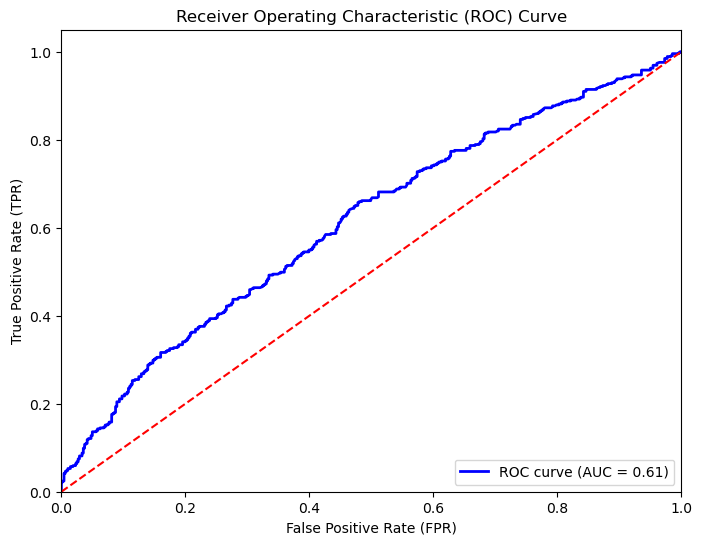

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Get the ROC curve data from the BinaryClassificationEvaluator
results = predictions.select(['Voters_Turnout', 'probability']).rdd.map(lambda row: (float(row['probability'][1]), float(row['Voters_Turnout'])))

# Extract the false positive rate (FPR), true positive rate (TPR), and thresholds
fpr, tpr, thresholds = roc_curve(results.map(lambda x: x[1]).collect(), results.map(lambda x: x[0]).collect())

# Calculate the Area Under Curve (AUC) score
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


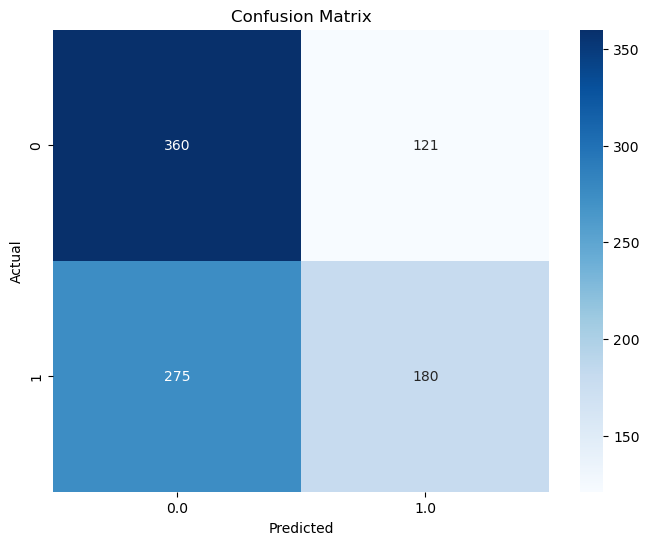

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert the confusion matrix to a Pandas DataFrame
conf_matrix_df = conf_matrix.toPandas()

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_df.pivot("Voters_Turnout", "prediction", "count"), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Results

A logistic regression model with lifestyle interests as predictors resulted in a AUC metric of 57%. This was expected as lifestyle interests did not seem to have a large impact on voter turnout in comparison to more significant variables, like age, gender, and income. When we consider a logistic regression model with age, gender, and household income as predictors, the AUC is 58.4%. If we combine lifestyle interests, age, gender, and household income as predictors, we achieve an AUC of 61.2%.

### Discussion

The analysis conducted in this study sheds light on several key factors influencing voter turnout and disparities across different demographic groups in Georgia. Our investigation revealed significant variations in voter participation based on age, gender, income level, ethnicity, and lifestyle interests. Here, we discuss the implications of our findings and their relevance to understanding voter behavior and designing effective strategies for increasing civic engagement.

#### Age and Voter Turnout
One of the prominent findings of our study is the substantial difference in voter turnout between younger and older demographics. Younger populations, particularly those in college or with lower incomes, exhibited lower participation rates compared to older individuals. This trend highlights the importance of targeting outreach and educational campaigns towards younger voters to increase their awareness of civic responsibilities and the impact of political decisions on their lives. Strategies such as providing voter education in educational institutions and leveraging digital platforms for engagement could be effective in mobilizing younger voters.

#### Gender Disparities
Our analysis also uncovered gender disparities in voter turnout, with females consistently showing higher participation rates across different income levels. Understanding the factors driving this disparity is crucial for developing initiatives to enhance male voter turnout. Possible strategies include addressing barriers to voting faced by men, such as accessibility issues or lack of awareness about voting procedures. Additionally, targeted messaging and outreach campaigns tailored to specific gender demographics could help bridge the gap in voter turnout between males and females.

#### Ethnicity and Socioeconomic Factors
Ethnicity and socioeconomic status were found to be significant determinants of voter turnout. While older age groups, particularly those of European descent, exhibited higher participation rates, disparities emerged among younger ethnic groups. These findings suggest that factors beyond income, such as cultural influences and historical contexts, play a role in shaping voting behavior. Addressing barriers to voting among marginalized communities and promoting inclusivity in the electoral process are essential steps towards achieving equitable representation and participation.

#### Lifestyle Interests
Analyzing lifestyle interests provided additional insights into voter behavior. While certain interests, such as exercise and health-related activities, showed a positive correlation with voter turnout, others like online education and electronic gaming displayed lower engagement in civic activities. These findings emphasize the need to tailor outreach efforts based on individuals' interests and priorities, ensuring that diverse segments of the population are actively engaged in the democratic process.



### Conclusion

Based on our findings we can conclude that compared to lifestyle variables, factors such as age, gender, and household income were the most impactful in determining voter turnout. In addition to these factors, we found that ethnicity could play a role in voter turnout as a few of the plots we created showed relationships between ethnicity and age as well as gender. In terms of a political campaign to encourage more voting, the young and lower income population should be targeted to increase voter turnout.

Our study underscores the multifaceted nature of voter participation disparities in Georgia. By leveraging big data analytics and advanced tools like PySpark, we were able to uncover patterns and trends that contribute to these disparities. Our findings highlight the importance of targeted interventions, educational initiatives, and policy changes to promote inclusive and equitable voter engagement.

Moving forward, future research should focus on refining predictive models, exploring additional variables that influence voter behavior, and evaluating the effectiveness of intervention strategies. By addressing the underlying causes of voter turnout disparities and fostering a culture of civic engagement, we can work towards a more representative and participatory democracy in Georgia and beyond.